## author: Levon Abramian, J4132
## Task 2. Algorithms for unconstrained nonlinear optimization. Direct methods

## The use of direct methods (one-dimensional methods of exhaustive search, dichotomy, golden section search; multidimensional methods of exhaustive search, Gauss (coordinate descent), Nelder-Mead) in the tasks of unconstrained nonlinear optimization

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy

In [2]:
EPS = 0.0001

In [3]:
alpha = random.random()
beta = random.random()
sigma = np.random.normal(size=101)
x_list = np.linspace(0, 1, 101)
y_list = alpha * x_list + beta + sigma

In [4]:
alpha, beta

(0.4925963503826428, 0.342434017808671)

In [5]:
class Point:

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __add__(self, other):
        x = self.x + other.x
        y = self.y + other.y
        return Point(x, y)

    def __hash__(self):
        return 1

    def __str__(self):
        return f'{self.x}, {self.y}'

    def __repr__(self):
        return f'{self.x}, {self.y}'

    def __rmul__(self, other):
        x = self.x * other
        y = self.y * other
        return Point(x, y)

    def __truediv__(self, other):
        x = self.x / other
        y = self.y / other
        return Point(x, y)

    def __sub__(self, other):
        x = self.x - other.x
        y = self.y - other.y
        return Point(x, y)

In [18]:
def f_1(x):
    return x**3

def f_2(x):
    return abs(x - 0.2)

def f_3(x):
    return x * math.sin(1/x)

def F_1(x, a, b):
    return a * x + b

def F_2(x, a, b):
    return a / (1 + b * x)

def D(a, b, F):
    D = 0
    for xi, yi in zip(x_list, y_list):
        D += (F(xi, a, b) - yi) ** 2
    return D

In [7]:
def plot_function(f, a, b, title=''):
    x_range = np.linspace(a, b, 100000)
    y = np.array([f(x) for x in x_range])
    plt.title(title)
    plt.plot(x_range, y)

In [8]:
def exhaustive_search(func, a, b, eps):
    min_point, min_value = a, func(a)

    current_point = a
    n_iter = 0
    
    while abs(b - current_point) >= eps:
        n_iter += 1

        current_value = func(current_point)
        
        if current_value < min_value:
            min_point, min_value = current_point, current_value
        
        current_point += eps
       

    return min_point, n_iter

In [9]:
def exhaustive_search_2D(func, start_point: Point, finish_point: Point, eps, F):
    min_point, min_value = start_point, func(start_point.x, start_point.y, F)

    current_point = start_point
    n_iter = 0
    
    while finish_point.x - current_point.x > eps:
        while finish_point.y - current_point.y > eps:
            n_iter += 1
    
            current_value = func(current_point.x, current_point.y, F)
            
            if current_value < min_value:
                min_point, min_value = current_point, current_value
            
            current_point = Point(current_point.x, current_point.y + eps)

        current_point = Point(current_point.x + eps, start_point.y)

    return min_point, n_iter

In [10]:
def dichotomy_search(func, a, b, eps):
    n_iter = 0
    
    while abs(a - b) > eps:
        n_iter += 1
        
        if func(a) < func(b):
            b = (a + b) / 2
        else:
            a = (a + b) / 2

    return (a + b) / 2, n_iter

In [11]:
def golden_search(func, a, b, eps):
    phi = (math.sqrt(5) + 1) / 2
    n_iter = 0
    while abs(a - b) > eps:
        n_iter += 1
        x_1, x_2 = b - (b - a) / phi, a + (b - a) / phi
        
        if func(x_1) <= func(x_2):
            b = x_2    
        else:
            a = x_1
    return (a + b) / 2, n_iter

In [12]:
def gauss_search(func, start_point: Point, finish_point: Point, eps, F):
    optim_point = start_point
    n_iter = 0
    cur_min_value = func(start_point.x, start_point.y, F)
    while True:
        cur_func = lambda x: func(optim_point.x, x, F)
        y_inner_point, iters = dichotomy_search(cur_func, start_point.y, finish_point.y, eps)
        n_iter += iters
        if abs(optim_point.y - y_inner_point) < eps:
            break
        
        optim_point = Point(optim_point.x, y_inner_point)

        cur_func =  lambda x: func(x, optim_point.y, F)
        x_inner_point, iters = dichotomy_search(cur_func, start_point.x, finish_point.x, eps)
        n_iter += iters
        if abs(optim_point.x - x_inner_point) < eps:
            break
        optim_point = Point(x_inner_point, optim_point.y)
    
    return optim_point, n_iter

In [13]:
def nelder_mead_search(func, F, alpha=1, beta=0.5, gamma=2, eps=0.001):
    # self.triangle_points = []
    v1 = Point(-0.99, -0.99)
    v2 = Point(-0.99, 1)
    v3 = Point(1, 1)
    n_iter = 0
    while True:
        adict = {
            v1: func(v1.x, v1.y, F),
            v2: func(v2.x, v2.y, F),
            v3: func(v3.x, v3.y, F)
        }
        
        points = sorted(adict.items(), key=lambda x: x[1])
        # print(points)
        b, g, w = points[0][0], points[1][0], points[2][0]

        mid = (g + b) / 2
        xr = mid + alpha * (mid - w)
 
        # reflection
        if func(xr.x, xr.y, F) < func(g.x, g.y, F):
            w = xr
        else:
            if func(xr.x, xr.y, F) < func(w.x, w.y, F):
                w = xr
            center = (w + mid) / 2

            if func(center.x, center.y, F) < func(w.x, w.y, F):
                w = center

        # if self.calculate(xr.tuple_from_data()) < self.calculate(b.tuple_from_data()):
        if func(xr.x, xr.y, F) < func(b.x, b.y, F):

            # expansion
            xe = mid + gamma * (xr - mid)
            if func(xe.x, xe.y, F) < func(xe.x, xe.y, F):
                w = xe
            else:
                w = xr
                
        if func(xr.x, xr.y, F) > func(g.x, g.y, F):

            # contraction
            xc = mid + beta * (w - mid)
            
            if func(xc.x, xc.y, F) < func(w.x, w.y, F):
                w = xc

        if abs(w.x - v1.x) + abs(w.y - v1.y) + abs(g.x - v2.x) + abs(g.y - v2.y) + abs(b.x - v3.x) + abs(b.y - v3.y) < eps:
            break
        n_iter += 1
        v1 = w
        v2 = g
        v3 = b
        
    return g, n_iter

In [14]:
print(nelder_mead_search(D, F=F_1))
print(nelder_mead_search(D, F=F_2))

(-0.11409796751606338, 0.6620449636281411, 25)
(0.6886231776834942, 0.2904872453217935, 28)


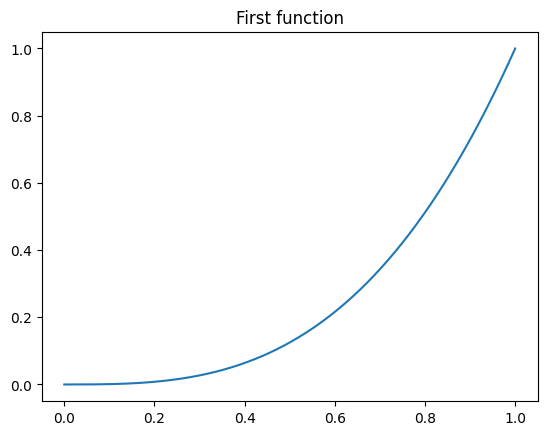

In [15]:
plot_function(f_1, a=0, b=1, title='First function')

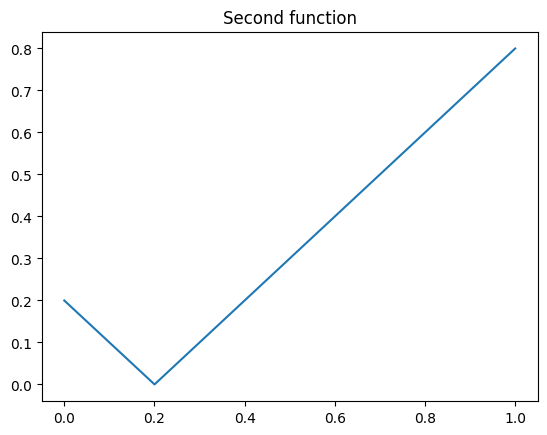

In [16]:
plot_function(f_2, a=0, b=1, title='Second function')

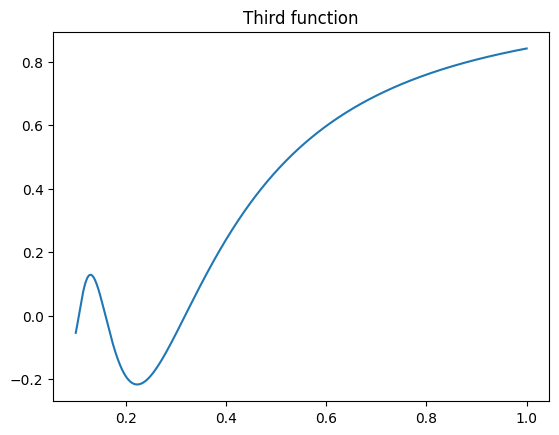

In [20]:
plot_function(f_3, a=0.1, b=1, title='Third function')

Trying to solve MSE problem. Limits: $a$ is between -1 and 1

In [36]:
x_1_1_min, n_1_1_min = exhaustive_search(f_1, a=0.0, b=1.0, eps=0.0001)
x_2_1_min, n_2_1_min = exhaustive_search(f_2, a=0.0, b=1.0, eps=0.0001)
x_3_1_min, n_3_1_min = exhaustive_search(f_3, a=0.01, b=1.0, eps=0.0001)

print(f'f1 min point = {x_1_1_min:.5}, itertion = {n_1_1_min}')
print(f'f2 min point = {x_2_1_min:.5}, itertion = {n_2_1_min}')
print(f'f3 min point = {x_3_1_min:.5}, itertion = {n_3_1_min}')

f1 min point = 0.0, itertion = 10000
f2 min point = 0.2, itertion = 10000
f3 min point = 0.2225, itertion = 9900


In [37]:
x_1_2_min, n_1_2_min = dichotomy_search(f_1, a=0.0, b=1.0, eps=0.0001)
x_2_2_min, n_2_3_min = dichotomy_search(f_2, a=0.0, b=1.0, eps=0.0001)
x_3_2_min, n_3_3_min = dichotomy_search(f_3, a=0.01, b=1.0, eps=0.0001)

print(f'f1 min point = {x_1_2_min:.5}, itertion = {n_1_2_min}')
print(f'f2 min point = {x_2_2_min:.5}, itertion = {n_2_3_min}')
print(f'f3 min point = {x_3_2_min:.5}, itertion = {n_3_3_min}')

f1 min point = 3.0518e-05, itertion = 14
f2 min point = 0.19998, itertion = 14
f3 min point = 0.22254, itertion = 14


In [38]:
x_1_3_min, n_1_3_min = golden_search(f_1, a=0.0, b=1.0, eps=0.0001)
x_2_3_min, n_2_3_min = golden_search(f_2, a=0.0, b=1.0, eps=0.0001)
x_3_3_min, n_3_3_min = golden_search(f_3, a=0.01, b=1.0, eps=0.0001)

print(f'f1 min point = {x_1_3_min:.5}, itertion = {n_1_3_min}')
print(f'f2 min point = {x_2_3_min:.5}, itertion = {n_2_3_min}')
print(f'f3 min point = {x_3_3_min:.5}, itertion = {n_3_3_min}')

f1 min point = 3.3053e-05, itertion = 20
f2 min point = 0.20002, itertion = 20
f3 min point = 0.22254, itertion = 20


It can be seen, that every method has a constant number of itertion. For the exhaustive search it always would be an integer part of $N=\frac{b-a}{\varepsilon}$, where $[a, b]$ - searching interval, $\varepsilon$ - precision. For the dichotomy search it always would be an integer part of $\log_2(N)$. For the dichotomy search it always would be an integer part of $\log_\phi(N)$, where $\phi =\frac{\sqrt 5 + 1}{2}$. Precision is the same because, that is algorithms stopping condition.

# PART II

Limits: $a$ and $b$ is in an interval [0.99; 1.00]. It is necessary to implement exhaustive search and Gauss search, but not necessary for Nelder-Mead method

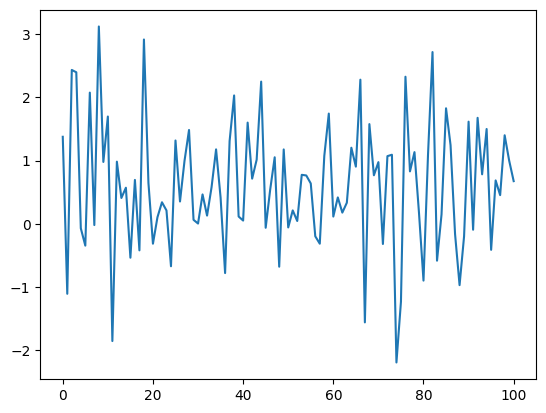

In [26]:
plt.plot(y_list)

In [27]:
min_point_exs_1, interation_exs_1 = exhaustive_search_2D(D, Point(-0.99, -0.99), Point(1, 1), eps=0.001, F=F_1)
min_point_exs_2, interation_exs_2 = exhaustive_search_2D(D, Point(-0.99, -0.99), Point(1, 1), eps=0.001, F=F_2)

print(f'F1 min point = {min_point_exs_1}, itertion = {interation_exs_1}')
print(f'F2 min point = {min_point_exs_2}, itertion = {interation_exs_2}')

F1 min point = -0.11399999999999921, 0.6620000000000014, itertion = 3956121
F2 min point = 0.6890000000000014, 0.2920000000000011, itertion = 3956121


In [28]:
min_point_gauss_1, interation_gauss_1 = gauss_search(D, Point(-0.99, -0.99), Point(1, 1), eps=0.001, F=F_1)
min_point_gauss_2, interation_gauss_2 = gauss_search(D, Point(-0.99, -0.99), Point(1, 1), eps=0.001, F=F_2)

print(f'F1 min point = {min_point_gauss_1}, itertion = {interation_gauss_1}')
print(f'F2 min point = {min_point_gauss_2}, itertion = {interation_gauss_2}')

F1 min point = -0.12180419921874999, 0.6671997070312501, itertion = 341
F2 min point = 0.7420190429687499, 0.5029858398437499, itertion = 143


In [29]:
min_point_nelder_1, interation_nelder_1 = nelder_mead_search(D, F=F_1)
min_point_nelder_2, interation_nelder_2 = nelder_mead_search(D, F=F_2)

print(f'F1 min point = {min_point_nelder_1}, itertion = {interation_nelder_1}')
print(f'F2 min point = {min_point_nelder_2}, itertion = {interation_nelder_2}')

F1 min point = -0.11409796751606338, 0.6620449636281411, itertion = 25
F2 min point = 0.6886231776834942, 0.2904872453217935, itertion = 28


Nelder-Mead has less iteration, because for an iteration this method make a lot of calculations, but generally the complexity is not so friendly (https://arxiv.org/pdf/1410.0390). According the article in the some situations iterations can be approximately $N^2$. The complexity of itetations for exhaustive search is $O(N^2)$, where $N=\frac{b-a}{\varepsilon}$, where $[a, b]$ - searching interval, $\varepsilon$ - precision. For the Gauss search complexity is $O(N \log N)$, but is depends on a method used for find optimal point in each step.

In [30]:
y_f1_test = [F_1(x, min_point_exs_1.x, min_point_exs_1.y) for x in x_list]
y_f2_test = [F_2(x, min_point_exs_2.x, min_point_exs_2.y) for x in x_list]
y_f1_gauss = [F_1(x, min_point_gauss_1.x, min_point_gauss_1.y) for x in x_list]
y_f2_gauss = [F_2(x, min_point_gauss_2.x, min_point_gauss_2.y) for x in x_list]
y_f1_nelder = [F_1(x, min_point_nelder_1.x, min_point_nelder_1.y) for x in x_list]
y_f2_nelder = [F_2(x, min_point_nelder_2.x, min_point_nelder_2.y) for x in x_list]

In the next cells shown the difference between methods and the difference between functions for each method

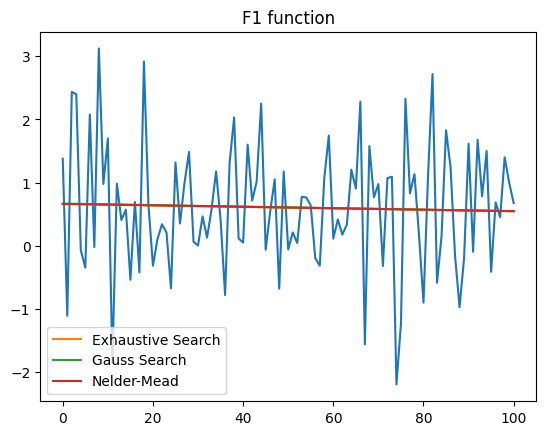

In [31]:
plt.plot(y_list)
plt.plot(y_f1_test, label='Exhaustive Search')
plt.plot(y_f1_gauss, label='Gauss Search')
plt.plot(y_f1_nelder, label='Nelder-Mead')
plt.title('F1 function')
plt.legend()

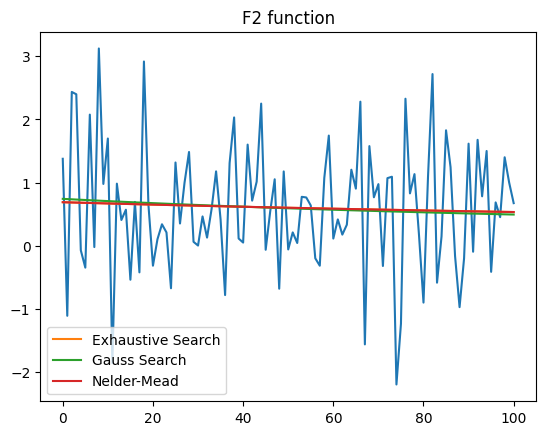

In [32]:
plt.plot(y_list)
plt.plot(y_f2_test, label='Exhaustive Search')
plt.plot(y_f2_gauss, label='Gauss Search')
plt.plot(y_f2_nelder, label='Nelder-Mead')
plt.title('F2 function')
plt.legend()

Text(0.5, 1.0, 'Exhaustive Search')

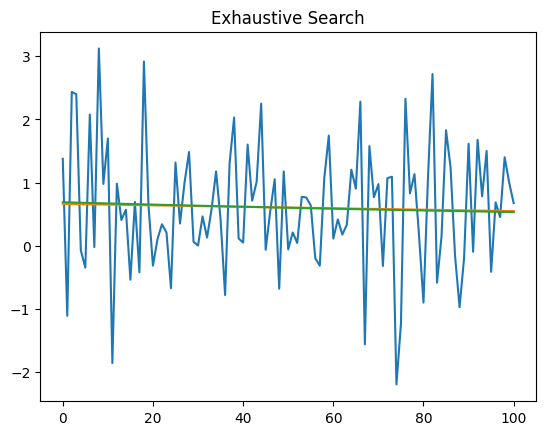

In [33]:
plt.plot(y_list)
plt.plot(y_f1_test)
plt.plot(y_f2_test)
plt.title('Exhaustive Search')

Text(0.5, 1.0, 'Gauss')

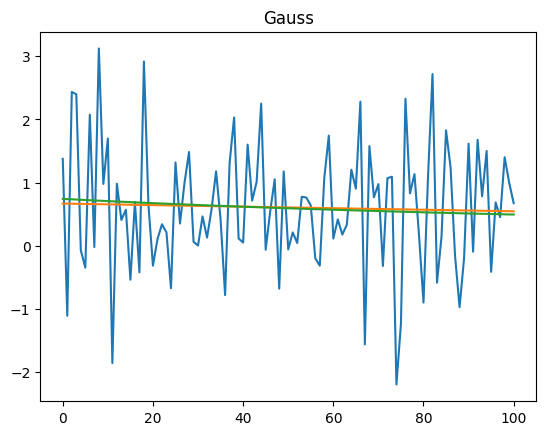

In [34]:
plt.plot(y_list)
plt.plot(y_f1_gauss)
plt.plot(y_f2_gauss)
plt.title('Gauss')

Text(0.5, 1.0, 'Nelder-Mead')

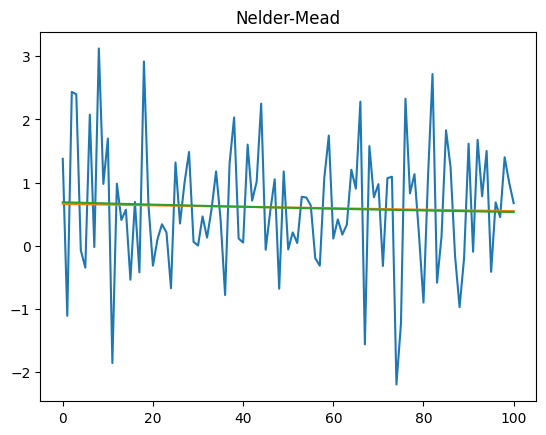

In [35]:
plt.plot(y_list)
plt.plot(y_f1_nelder)
plt.plot(y_f2_nelder)
plt.title('Nelder-Mead')

The plots shows that there is almost no differnce between methods.

# Conclusion

Obtained results confirm the theoretical rules. For the getting difference optimal point better to made stopping option as maximum of iteration or calculation. There was shown that exhaustive dearch does a lot of iteration to find point of minimum.